In [1]:
import xarray as xr
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

绘制MPAS输出降水的时间序列，和CMORPH之间的对应，以及误差；便于说明问题绘制了分位数图

In [2]:
year = "2003"
diri = "/m2data2/yycheng/yycheng/MPAS/92-25km_VR_"+year+"/postprocess/temp_data/"
fili = year+"_daily_precip_combine_CMORPH_MPAS.nc"
ds_disk = xr.open_dataset(diri + fili)
ds_disk

<xarray.Dataset>
Dimensions:        (Time: 153, lat: 160, latitude: 160, lon: 320, longitude: 320, time: 153)
Coordinates:
  * time           (time) datetime64[ns] 2003-04-01 2003-04-02 ... 2003-08-31
  * lat            (lat) float32 15.125 15.375 15.625 ... 54.375 54.625 54.875
  * lon            (lon) float32 60.125 60.375 60.625 ... 139.625 139.875
  * Time           (Time) datetime64[ns] 2003-04-01 2003-04-02 ... 2003-08-31
  * latitude       (latitude) float32 15.124999 15.374997 ... 54.874992
  * longitude      (longitude) float32 60.124992 60.374996 ... 139.87498
Data variables:
    precip_CMORPH  (time, lat, lon) float32 ...
    precip_MPAS    (Time, latitude, longitude) float64 ...
    precip_grid    (Time, latitude, longitude) float64 ...
    precip_conv    (Time, latitude, longitude) float64 ...

In [3]:
precip_obs = ds_disk["precip_CMORPH"]
precip_mod = ds_disk["precip_MPAS"]
obs_mean = precip_obs.mean(dim=["lon","lat"])
mod_mean = precip_mod.mean(dim=["longitude","latitude"])

In [4]:
# test = ds_disk.data_vars.keys()
# ds_disk[list(test)[1]]
test = dict(ds_disk.data_vars)
# test.get('precip_CMORPH')

In [5]:
df_obs = obs_mean.to_dataframe()
df_mod = mod_mean.to_dataframe()
# df_total_error = df_obs - df_mod
test   = np.squeeze(df_obs.values - df_mod.values) # 去掉冗余的维度
minus  = pd.Series(test,index=df_obs.index,name = 'CMORPH - MPAS')
# obs_mean_dict = {}


In [6]:
pd_plot = pd.concat([df_obs, df_mod, minus], axis=1)
pd_plot.head()

,precip_CMORPH,precip_MPAS,CMORPH - MPAS
2003-04-01,1.336223,2.057569,-0.721346
2003-04-02,0.855864,1.701747,-0.845883
2003-04-03,0.891684,1.423617,-0.531933
2003-04-04,1.263897,1.964623,-0.700726
2003-04-05,0.631369,1.247780,-0.616411


<Figure size 432x432 with 0 Axes>

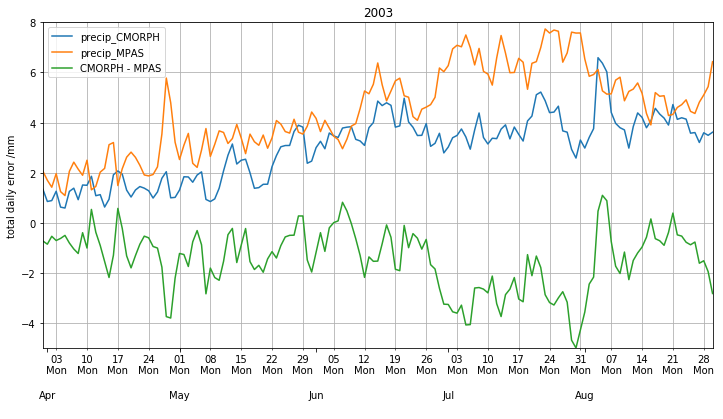

In [7]:
import matplotlib.dates as dates
# pd_plot = pd.concat([df_obs, df_mod,minus], axis=1)
plt.figure(figsize=(6,6))

ymin = -5.
ymax = 8.
idx = pd.date_range('2003-04-01', '2003-09-01')
# s = pd.Series(np.random.randn(len(idx)), index=idx)

# fig, ax = plt.subplots()
# ax.plot_date(idx.to_pydatetime(), 'v-')
ax = pd_plot.plot(figsize=(12,6))
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n'))
# ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
# plt.tight_layout()
# plt.show()
ax.set_ylabel("total daily error /mm")
plt.title(year)
plt.savefig("./output_pic/precip_check_timeseries/"+year+"_time_series.png")

In [8]:
quantile_obs = precip_obs.quantile(np.linspace(0,1,101),dim=list(precip_obs.coords)[0:3])
quantile_mod = precip_mod.quantile(np.linspace(0,1,101),dim=list(precip_mod.coords)[0:3])
quantile_dict = {"quantile_obs":pd.Series(quantile_obs,index=np.linspace(0,1,101)), \
"mod_series":pd.Series(quantile_mod,index=np.linspace(0,1,101))}
quantile_df = pd.DataFrame(quantile_dict)
quantile_df.head()




,quantile_obs,mod_series
0.00,0.0,-0.015798
0.01,0.0,0.000000
0.02,0.0,0.000000
0.03,0.0,0.000000
0.04,0.0,0.000000


In [9]:
from plotnine import *
from plotnine.data import *

ggplottest = (
    ggplot(pd_plot,aes(x='precip_CMORPH',y='precip_MPAS'))
    # + geom_density(alpha=0.1)
    + theme(
    panel_grid=element_line(color="blue"),

    panel_grid_major=element_line(size=1.4, alpha=1),
    panel_grid_major_x=element_line(linetype='dashed'),
    panel_grid_major_y=element_line(linetype='dashdot'),

    panel_grid_minor=element_line(alpha=.25),
    panel_grid_minor_x=element_line(color="blue"),
    panel_grid_minor_y=element_line(color="blue"),
    
    panel_ontop=False  # puts the points behind the grid
 )
    + geom_point()
    # + panel_grid()
    # + position_identity()
    # + geom_smooth(method='lm')
    + geom_smooth(method='lm', stat='stat_smooth', position='identity',
            na_rm=False, inherit_aes=True, show_legend=True,
            legend_fill_ratio=0.95)
    + xlab('precip_CMORPH')
    + ylab('precip_MPAS')
    + coord_fixed(ratio = 1,xlim=(0,8),ylim=(0,8))
    # + coord_cartesian(xlim=(0,8),ylim=(0,8),expand=True)
    # + xlim(0,8)
    # + ylim(0,8)
    # + panel_grid_major()
    # + geom_label(title='?')
    + geom_abline(intercept=0, slope=1,color='r',linetype="dashed")
)
ggplottest
# ggplottest.save(ggplot, format="png", path="./output_pic/precip_check_timeseries/")
ggplottest.save("./output_pic/precip_check_timeseries/"+year+"_scatter.png", width=10, height=10, dpi=300)      

/m2data2/yycheng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 10 x 10 in image.
  from_inches(height, units), units))
/m2data2/yycheng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./output_pic/precip_check_timeseries/2003_scatter.png
  warn('Filename: {}'.format(filename))


In [10]:
from plotnine import *
from plotnine.data import *
mpg.head()
ggplottest2 = (
    ggplot(quantile_df,aes(x='quantile_obs',y='mod_series'))
    # + geom_density(alpha=0.1)
    + theme(
    panel_grid=element_line(color="blue"),

    panel_grid_major=element_line(size=1.4, alpha=1),
    panel_grid_major_x=element_line(linetype='dashed'),
    panel_grid_major_y=element_line(linetype='dashdot'),

    panel_grid_minor=element_line(alpha=.25),
    panel_grid_minor_x=element_line(color="blue"),
    panel_grid_minor_y=element_line(color="blue"),

    panel_ontop=False  # puts the points behind the grid
 )
    + geom_point()
    # + panel_grid()
    # + position_identity()
    # + geom_smooth(method='lm')
    + xlab('precip_CMORPH')
    + ylab('precip_MPAS')
    + coord_fixed(ratio = 1,xlim=(0,40),ylim=(0,40))
    # + coord_cartesian(xlim=(0,8),ylim=(0,8),expand=True)
    # + xlim(0,8)
    # + ylim(0,8)
    # + panel_grid_major()
    + geom_abline(intercept=0, slope=1,color='r',linetype="dashed")      
)
ggplottest2.save("./output_pic/precip_check_timeseries/"+year+"_quantile.png", width=10, height=10, dpi=300)

/m2data2/yycheng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 10 x 10 in image.
  from_inches(height, units), units))
/m2data2/yycheng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./output_pic/precip_check_timeseries/2003_quantile.png
  warn('Filename: {}'.format(filename))
